In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
sns.set()

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

#Importing Classification algorithms

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    SGDClassifier,
    Perceptron,
    PassiveAggressiveClassifier,
    RidgeClassifier, 
    RidgeClassifierCV
)

from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import  GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from rgf.sklearn import RGFClassifier, FastRGFClassifier
from gpboost import GPBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    ExtraTreesClassifier, 
    IsolationForest, 
    BaggingClassifier, 
    HistGradientBoostingClassifier
)

from imblearn.ensemble import (
    EasyEnsembleClassifier, 
    RUSBoostClassifier, 
    BalancedBaggingClassifier, 
    BalancedRandomForestClassifier 
)

seed = 351

In [2]:
#importing files

X_train_pars = pd.read_csv('X_train_pars.csv')
X_test_pars = pd.read_csv('X_test_pars.csv')

y_train = pd.read_csv('y_train_preprocessed.csv')
y_test = pd.read_csv('y_test_preprocessed.csv')
TEST_DF_pars = pd.read_csv('TEST_DF_pars.csv')

In [3]:
class classif_models:
    
    def __init__(self, Xtrain, ytrain, cv):
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.cv = cv
        
    def check_clf_models(self):

        models = [
            LogisticRegression(),
            LogisticRegressionCV(cv=10),
            SGDClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
            Perceptron(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
            PassiveAggressiveClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
            RidgeClassifier(),
            RidgeClassifierCV(cv=10),
            LinearSVC(loss = 'hinge'),
            SVC(kernel = 'rbf'),
            NuSVC(),
            KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
            GaussianNB(), 
            BernoulliNB(),
            MLPClassifier(tol=0.1, early_stopping = True, validation_fraction = 0.2),
            GaussianProcessClassifier()
        ]

        final_f1_score = []
        final_score = []
        final_score_std = []
        final_roc_auc_score = []
        final_mcc_score = []
        model_names = []

        for model in models:
            pipe = Pipeline(steps = [('scaler', StandardScaler()), (type(model).__name__, model)])
            score = [] 
            f1_score = []
            roc_auc_score = []
            mcc_score = []
            fold_no = 1 
            for train_index, test_index in self.cv.split(self.Xtrain, self.ytrain): 
                X_train_kfold, X_val_kfold = self.Xtrain[train_index], self.Xtrain[test_index] 
                y_train_kfold, y_val_kfold = self.ytrain[train_index], self.ytrain[test_index] 
                pipe.fit(X_train_kfold, y_train_kfold) 
                y_pred = pipe.predict(X_val_kfold)
                score.append(metrics.accuracy_score(y_val_kfold, y_pred))
                f1_score.append(metrics.f1_score(y_val_kfold, y_pred))
                mcc_score.append(metrics.matthews_corrcoef(y_val_kfold, y_pred))

                if hasattr(model, "predict_proba"):
                    roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                               pipe.predict_proba(X_val_kfold)[:, 1]))
                else: 
                    roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                               pipe.decision_function(X_val_kfold)))

                fold_no += 1
            final_score.append(np.round(np.mean(score)*100,3))
            final_score_std.append(np.round(np.std(score)*100,3))
            final_f1_score.append(np.round(np.mean(f1_score)*100,3))
            final_roc_auc_score.append(np.round(np.mean(roc_auc_score)*100,3))
            final_mcc_score.append(np.round(np.mean(mcc_score)*100,3))
            model_names.append(type(model).__name__)

    #Using Ensemble Models

        tree_models = [
            DecisionTreeClassifier(criterion = 'entropy', max_depth = 6),
            RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6), 
            XGBClassifier(use_label_encoder=False, eval_metric = 'error'), 
            CatBoostClassifier(verbose = False, loss_function='CrossEntropy', eval_metric='TotalF1'), 
            LGBMClassifier(), 
            AdaBoostClassifier(), 
            GradientBoostingClassifier(), 
            BaggingClassifier(), 
            ExtraTreesClassifier(criterion = 'entropy', max_depth = 6), 
            HistGradientBoostingClassifier(), 
            EasyEnsembleClassifier(), 
            RUSBoostClassifier(), 
            BalancedBaggingClassifier(), 
            BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6), 
            RGFClassifier(loss = 'Log', algorithm='RGF_Sib'), 
            FastRGFClassifier(loss='LOGISTIC'),
            GPBoostClassifier()
        ]

        for model in tree_models:
            score = [] 
            f1_score = []
            mcc_score = []
            fold_no = 1 
            for train_index, test_index in self.cv.split(self.Xtrain,self.ytrain): 
                X_train_kfold, X_val_kfold = self.Xtrain[train_index], self.Xtrain[test_index] 
                y_train_kfold, y_val_kfold = self.ytrain[train_index], self.ytrain[test_index] 
                classifier = model 
                classifier.fit(X_train_kfold, y_train_kfold) 
                y_pred = classifier.predict(X_val_kfold)
                
                score.append(metrics.accuracy_score(y_val_kfold, y_pred))
                
                f1_score.append(metrics.f1_score(y_val_kfold, y_pred))
                
                roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                           classifier.predict_proba(X_val_kfold)[:, 1]))
                
                mcc_score.append(metrics.matthews_corrcoef(y_val_kfold, y_pred))

                fold_no += 1
            
            final_score.append(np.round(np.mean(score)*100,3))
            final_score_std.append(np.round(np.std(score)*100,3))
            final_f1_score.append(np.round(np.mean(f1_score)*100,3))
            final_roc_auc_score.append(np.round(np.mean(roc_auc_score)*100,3))
            final_mcc_score.append(np.round(np.mean(mcc_score)*100,3))
            model_names.append(type(model).__name__)


        self.df = pd.DataFrame({
                'Models': model_names, 
                'Accuracy %': final_score, 
                'Acc_STD %': final_score_std, 
                'F1_Score %':final_f1_score,
                'ROC_AUC_Score %' :final_roc_auc_score, 
                'MCC_Score %': final_mcc_score
            }).sort_values('F1_Score %', ascending = False, ignore_index = True).style.\
                                                                highlight_max(color = 'green')

        return self.df


In [4]:
%%time

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state=seed)

all_models = classif_models(X_train_pars.values, y_train.Loan_Status.values, cv = skf)

all_models.check_clf_models()

Wall time: 2min 13s


In [400]:
#for evaluating model

class validate_on_test:
    
    def __init__(self, model, Xtrain, ytrain, Xtest, ytest, cv, beta):
        self.model = model
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.ytest = ytest
        self.cv = cv
        self.beta = beta
        
    def evaluate_model(self):
        
        from texttable import Texttable
        t = Texttable()
        
        model_name = type(self.model).__name__
        
        print('================================================')
        print(f'       Model: *** {model_name} ***')
        print('================================================')
        print()

        accuracy = []
        f1_score = []
        roc_auc_score = []
        fold_no = 1
        
        print('Cross Validation Results on training set....')
        
        for train_index, test_index in self.cv.split(self.Xtrain,self.ytrain):
            X_train_kfold, X_val_kfold = self.Xtrain[train_index], self.Xtrain[test_index]
            y_train_kfold, y_val_kfold = self.ytrain[train_index], self.ytrain[test_index]

            classifier = self.model

            classifier.fit(X_train_kfold, y_train_kfold) 
            y_pred = classifier.predict(X_val_kfold)
            y_probs = classifier.predict_proba(X_val_kfold)
            
            accuracy.append(np.round(metrics.accuracy_score(y_val_kfold, y_pred)*100,3))
            f1_score.append(np.round(metrics.f1_score(y_val_kfold, y_pred)*100,3))
            roc_auc_score.append(np.round(metrics.roc_auc_score(y_val_kfold, y_probs[:,1])*100,3))
            
            fold_no += 1
        
        for i in range(1,11):
            t.add_rows([['fold #', 'Accuracy %', 'f1 %', 'ROC-AUC %'], [[i], 
                                                                        accuracy[i-1], 
                                                                        f1_score[i-1], 
                                                                        roc_auc_score[i-1]]])
        print(t.draw())
        
        print()
        print(f'Mean CV f1 Score: {np.mean(f1_score)} ± {np.std(f1_score):.1f} %')
        print()
        print(f'Mean CV Accuracy: {np.mean(accuracy)} ± {np.std(accuracy):.1f} %')
        print()
        print(f'Mean CV ROC-AUC: {np.mean(roc_auc_score)} ± {np.std(roc_auc_score):.1f} %')
        print()
        print("---" * 40)

        y_pred = classifier.predict(self.Xtest)
        y_probs = classifier.predict_proba(self.Xtest)
        
        self.y_probs = y_probs

        print()
        print('====================================')
        print("Classification report on Test set:")
        print('====================================')
        print()
        print(metrics.classification_report(self.ytest, y_pred))
        print()
        print("---" * 40)
        print()
        print('=============================================================')
        print(f'*** {model_name} scores on TEST set ***')
        print('=============================================================')
        print()
        print(f'** F1 score: {metrics.f1_score(self.ytest, y_pred)*100:.4f} % **')
        print() 
        print(f'** Accuracy: {metrics.accuracy_score(self.ytest, y_pred)*100:.4f} % **')
        print()
        print(f'** ROC AUC Score: {metrics.roc_auc_score(self.ytest, y_probs[:,1])*100:.4f} % **')
        print()
        
        print("---" * 40)
        print()

        # apply threshold to positive probabilities to create labels
        print('Estimating new probability threshold.........Please Wait..............')
        print()
        
        thresholds = np.arange(0, 1, 0.001)

        # apply threshold to positive probabilities to create labels
        def to_labels(pos_probs, threshold):
            return (pos_probs >= threshold).astype('int')

        # evaluate each threshold
        self.scores = [metrics.fbeta_score(self.ytest, 
                                           to_labels(self.y_probs[:,1], t), 
                                           beta = self.beta) for t in thresholds]

        # get best threshold
        ix = np.argmax(self.scores)
        
        self.new_prob_threshold = thresholds[ix]
        
        print(f'** Threshold = {thresholds[ix]*100:.3f}, Fbeta-score = {self.scores[ix]*100:.3f} **')
        print()

        self.tuned_pred = np.where(classifier.predict_proba(self.Xtest)[:,1] > thresholds[ix],1,0).\
                                                                                      astype('int64')
        new_acc = metrics.accuracy_score(self.ytest, self.tuned_pred)
        new_f1 = metrics.f1_score(self.ytest, self.tuned_pred)
        
        print('==============================================================')
        print(f'*** New Scores with tuned probability threshold: {np.round(thresholds[ix]*100,3)} % ***')
        print('==============================================================')
        print()
        print(f'{model_name} F1 Score: {new_f1*100:.4f} %')
        print()
        print(f'{model_name} Accuracy: {new_acc*100:.4f} %')
        print()
        print("---" * 40)

        skplt.metrics.plot_roc(self.ytest, y_probs);
        
        print('====================================================')
        print(f'    *** ROC AUC Plot and Confusion Matrix ***')
        print('====================================================')
        
        fig = plt.figure(figsize = (15,5));
        ax1 = fig.add_subplot(121);
        ax2 = fig.add_subplot(122);
        
        skplt.metrics.plot_confusion_matrix(self.ytest, y_pred, ax = ax1, text_fontsize = 'large', 
                                            cmap='YlGn');
    
        
        skplt.metrics.plot_confusion_matrix(self.ytest, self.tuned_pred, ax = ax2, text_fontsize = 'large',
                                            cmap='YlGn');
        
        ax1.title.set_text('With Prob. Threshold = 50 %');
        ax2.title.set_text(f'With New Prob. Threshold = {thresholds[ix]*100:.2f} %');

# Gaussian Process Classifier

In [12]:
%%time

# For Logistic Regression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.gaussian_process.kernels import (
    RBF,
    DotProduct, 
    Matern, 
    RationalQuadratic,
    WhiteKernel, 
    ExpSineSquared 
)

params = [
    {'gpc__kernel': [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel(),
                     1*ExpSineSquared()]}
]

gpc = Pipeline(steps = [
    ('scaler', StandardScaler()), 
    ('gpc', GaussianProcessClassifier())
])

grid_search = GridSearchCV(estimator = gpc, 
                                 param_grid= params, 
                                 cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle = True), 
                                 scoring = 'roc_auc', n_jobs = -1) #To use all processors
tuning = 1
while tuning <2:
    
    grid_search.fit(X_train_pars, y_train)
    best_accuracy = grid_search.best_score_
    best_param = grid_search.best_params_
    print(f'tuning: {tuning}')
    print('Logistic Regression Params:')
    print(f'Best Accuracy: {best_accuracy*100} %')
    print(f'Best Parameters: {best_param}')
    print()
    tuning +=1

tuning: 1
Logistic Regression Params:
Best Accuracy: 79.75629404931223 %
Best Parameters: {'gpc__kernel': 1**2 * Matern(length_scale=1, nu=1.5)}

Wall time: 36 s


       Model: *** Pipeline ***

Cross Validation Results on training set....
+--------+------------+--------+-----------+
| fold # | Accuracy % |  f1 %  | ROC-AUC % |
+========+============+========+===========+
| [1]    | 77.358     | 85.714 | 76.307    |
+--------+------------+--------+-----------+
| [2]    | 84.615     | 89.474 | 79.496    |
+--------+------------+--------+-----------+
| [3]    | 84.615     | 89.744 | 84.538    |
+--------+------------+--------+-----------+
| [4]    | 82.692     | 88.889 | 81.424    |
+--------+------------+--------+-----------+
| [5]    | 78.846     | 86.076 | 79.167    |
+--------+------------+--------+-----------+
| [6]    | 78.846     | 86.747 | 73.611    |
+--------+------------+--------+-----------+
| [7]    | 84.615     | 89.744 | 73.264    |
+--------+------------+--------+-----------+
| [8]    | 88.462     | 92.308 | 84.549    |
+--------+------------+--------+-----------+
| [9]    | 80.769     | 87.500 | 72.396    |
+--------+------------+

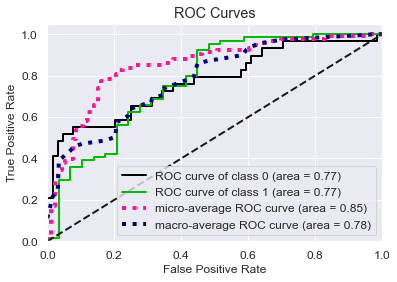

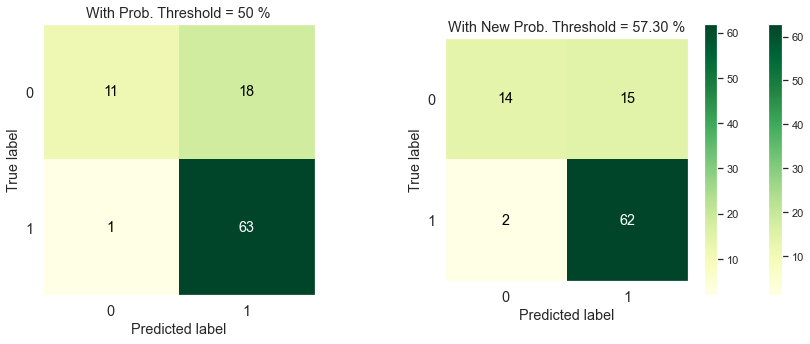

In [401]:
gpc = Pipeline(steps = [
    ('scaler', StandardScaler()), 
    ('gpc', GaussianProcessClassifier(1**2 * Matern(length_scale=1, nu=1.5)))
])

result = validate_on_test(gpc,
                          X_train_pars.values,
                          y_train.Loan_Status.values,
                          X_test_pars.values,
                          y_test.Loan_Status.values,
                          cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
                          beta = 1)

result.evaluate_model()

# ExtraTreeClassifier

Best Accuracy: -79.16369047619047 %
Best parameters:
n_estimators=10, 
criterion='entropy',
max_depth=6,
min_samples_split=0.63621, 
min_samples_leaf=1, 
max_features='sqrt', 
ccp_alpha=0.00010, 
bootstrap=False, 
class_weight='balanced' 
Wall time: 17min 10s


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

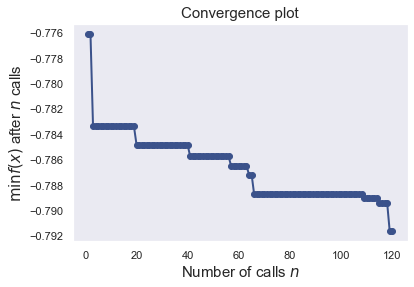

In [255]:
%%time
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical #Real = float
from skopt.utils import use_named_args

param_grid = [
    Integer(10, 2000, name="n_estimators"),
    Categorical(['gini', 'entropy'], name = "criterion"),
    Integer(1,7, name = "max_depth"),
    Real(0.0001, 0.999, name = "min_samples_split"),
    Integer(1,30, name = "min_samples_leaf"),
    Categorical(['sqrt', 'log2'], name = "max_features"),
    Real(0.0001, 0.035, name="ccp_alpha"),
    Categorical([True, False], name = "bootstrap"),
    Categorical(['balanced', 'balanced_subsample'], name = "class_weight")
]

model = ExtraTreesClassifier(n_jobs=-1)

@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    model.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(cross_val_score(model, X_train_pars, y_train,
                                    cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle=True),
                                    n_jobs=-1, 
                                    scoring='roc_auc')
                   )

    # negate because we need to minimize
    return -value

 

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=20, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=120, # the number of subsequent evaluations of f(x)
    random_state=seed, 
    n_jobs=-1,
)

print(f'Best Accuracy: {gp_.fun*100} %')  

print("""Best parameters:
=========================
n_estimators=%d, 
criterion='%s',
max_depth=%d,
min_samples_split=%.5f, 
min_samples_leaf=%d, 
max_features='%s', 
ccp_alpha=%.5f, 
bootstrap=%s, 
class_weight='%s' """ % (gp_.x[0], gp_.x[1], gp_.x[2], gp_.x[3], gp_.x[4], gp_.x[5], gp_.x[6], gp_.x[7],
                        gp_.x[8]))

plot_convergence(gp_);

       Model: *** ExtraTreesClassifier ***

Cross Validation Results on training set....
+--------+------------+--------+-----------+
| fold # | Accuracy % |  f1 %  | ROC-AUC % |
+========+============+========+===========+
| [1]    | 77.358     | 85.714 | 73.938    |
+--------+------------+--------+-----------+
| [2]    | 84.615     | 89.474 | 83.025    |
+--------+------------+--------+-----------+
| [3]    | 82.692     | 88.608 | 85.798    |
+--------+------------+--------+-----------+
| [4]    | 82.692     | 88.889 | 81.597    |
+--------+------------+--------+-----------+
| [5]    | 76.923     | 85     | 78.559    |
+--------+------------+--------+-----------+
| [6]    | 78.846     | 86.747 | 74.913    |
+--------+------------+--------+-----------+
| [7]    | 82.692     | 88.608 | 69.010    |
+--------+------------+--------+-----------+
| [8]    | 88.462     | 92.308 | 83.333    |
+--------+------------+--------+-----------+
| [9]    | 76.923     | 85.366 | 74.913    |
+--------+-

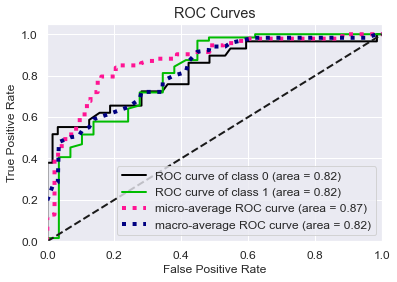

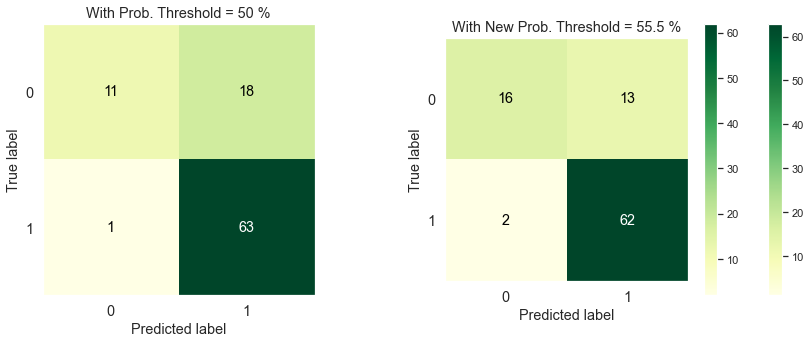

In [275]:
et = ExtraTreesClassifier(
    n_jobs=-1, 
    n_estimators=384, 
    criterion='gini',
    max_depth=5,
    min_samples_split=0.01445, 
    min_samples_leaf=4, 
    max_features='sqrt', 
    ccp_alpha=0.03168, 
    bootstrap=True, 
    class_weight='balanced_subsample'
)

result = validate_on_test(et,
                          X_train_pars.values,
                          y_train.Loan_Status.values,
                          X_test_pars.values,
                          y_test.Loan_Status.values,
                          cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
                          beta = 1)

result.evaluate_model()

# CatBoost Classifier

Best Accuracy: -79.74010854341736 %
Best parameters:
depth=6, 
iterations=225,
learning_rate=0.00100, 
l2_leaf_reg=83.59082,
border_count=118, 
boosting_type='Ordered' 
Wall time: 17min 16s


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

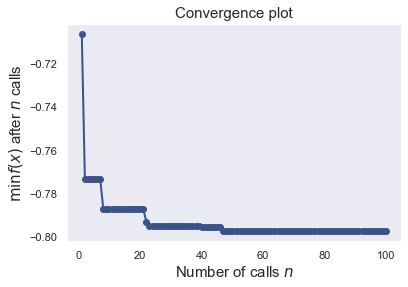

In [82]:
%%time
from sklearn.model_selection import cross_val_score
from skopt import gbrt_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical #Real = float
from skopt.utils import use_named_args
 
from catboost import CatBoostClassifier

param_grid = [
    Integer(1, 7, name="depth"),
    Integer(200, 1000, name="iterations"),
    Real(0.001, 0.4, name = "learning_rate"),
    Real(1.0, 100.0, name = "l2_leaf_reg"),
    Integer(5, 200, name="border_count"),
    Categorical(['Ordered', 'Plain'], name = "boosting_type")
]

cat = CatBoostClassifier(verbose = False, loss_function='CrossEntropy', eval_metric='AUC')

@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    cat.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(cross_val_score(cat, X_train_pars, y_train,
                                    cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle=True),
                                    n_jobs=-1, scoring='roc_auc')
                   )

    # negate because we need to minimize
    return -value

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=20, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=100, # the number of subsequent evaluations of f(x)
    random_state=seed, 
)

print(f'Best Accuracy: {gp_.fun*100} %')  

print("""Best parameters:
=========================
depth=%d, 
iterations=%d,
learning_rate=%.5f, 
l2_leaf_reg=%.5f,
border_count=%d, 
boosting_type='%s' """ % (gp_.x[0], gp_.x[1], gp_.x[2], gp_.x[3], gp_.x[4], gp_.x[5]))
print()

plot_convergence(gp_);

       Model: *** CatBoostClassifier ***

Cross Validation Results on training set....
+--------+------------+--------+-----------+
| fold # | Accuracy % |  f1 %  | ROC-AUC % |
+========+============+========+===========+
| [1]    | 77.358     | 85.714 | 73.529    |
+--------+------------+--------+-----------+
| [2]    | 84.615     | 89.474 | 75.126    |
+--------+------------+--------+-----------+
| [3]    | 82.692     | 88.608 | 85.714    |
+--------+------------+--------+-----------+
| [4]    | 82.692     | 88.889 | 87.326    |
+--------+------------+--------+-----------+
| [5]    | 76.923     | 85     | 75.521    |
+--------+------------+--------+-----------+
| [6]    | 78.846     | 86.747 | 78.819    |
+--------+------------+--------+-----------+
| [7]    | 82.692     | 88.608 | 75.521    |
+--------+------------+--------+-----------+
| [8]    | 88.462     | 92.308 | 86.458    |
+--------+------------+--------+-----------+
| [9]    | 76.923     | 85.366 | 73.090    |
+--------+---

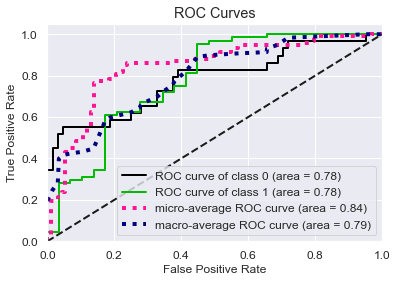

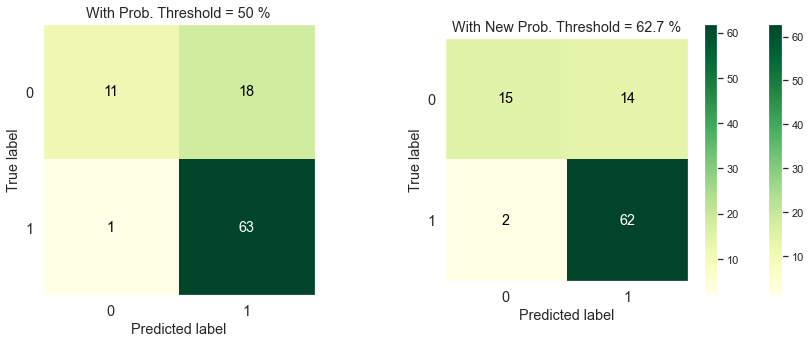

In [263]:
cat = CatBoostClassifier(
    verbose = False, 
    loss_function='CrossEntropy', 
    eval_metric='TotalF1', 
    depth=6, 
    iterations=262,
    learning_rate=0.00368, 
    l2_leaf_reg=93.38356,
    border_count=182, 
    boosting_type='Plain'
)

result = validate_on_test(cat,
                          X_train_pars.values,
                          y_train.Loan_Status.values,
                          X_test_pars.values,
                          y_test.Loan_Status.values,
                          cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
                          beta = 0.9)

result.evaluate_model()

# LogisticRegression

In [182]:
%%time

# For Logistic Regression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

params = [
    {'logit__C': np.arange(0.0,11,0.1), 
     'logit__class_weight': ['balanced'], 
     'logit__penalty': ['l2'], 
     'logit__solver': ['saga']},
#     {'logit__C': np.arange(0.0,1.1,0.1),
#      'logit__class_weight': ['balanced'],
#      'logit__penalty': ['l1', 'l2', 'elasticnet'], 
#      'logit__solver': ['liblinear']}
]

logit = Pipeline(steps = [
    ('scaler', StandardScaler()), 
    ('logit', LogisticRegression())
])

grid_search = RandomizedSearchCV(estimator = logit, 
                                 param_distributions= params, 
                                 cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle = True), 
                                 scoring = 'roc_auc', 
                                 n_jobs = -1) #To use all processors
tuning = 1
while tuning <=5:
    
    grid_search.fit(X_train_pars, y_train)
    best_accuracy = grid_search.best_score_
    best_param = grid_search.best_params_
    print(f'tuning: {tuning}')
    print('Logistic Regression Params:')
    print(f'Best Accuracy: {best_accuracy*100} %')
    print(f'Best Parameters: {best_param}')
    print()
    tuning +=1

tuning: 1
Logistic Regression Params:
Best Accuracy: 78.2607376283847 %
Best Parameters: {'logit__solver': 'saga', 'logit__penalty': 'l2', 'logit__class_weight': 'balanced', 'logit__C': 6.2}

tuning: 2
Logistic Regression Params:
Best Accuracy: 78.24393090569562 %
Best Parameters: {'logit__solver': 'saga', 'logit__penalty': 'l2', 'logit__class_weight': 'balanced', 'logit__C': 3.7}

tuning: 3
Logistic Regression Params:
Best Accuracy: 78.24393090569562 %
Best Parameters: {'logit__solver': 'saga', 'logit__penalty': 'l2', 'logit__class_weight': 'balanced', 'logit__C': 8.8}

tuning: 4
Logistic Regression Params:
Best Accuracy: 78.24448529411765 %
Best Parameters: {'logit__solver': 'saga', 'logit__penalty': 'l2', 'logit__class_weight': 'balanced', 'logit__C': 0.30000000000000004}

tuning: 5
Logistic Regression Params:
Best Accuracy: 78.24393090569562 %
Best Parameters: {'logit__solver': 'saga', 'logit__penalty': 'l2', 'logit__class_weight': 'balanced', 'logit__C': 10.3}

Wall time: 1.71 s


       Model: *** Pipeline ***

Cross Validation Results on training set....
+--------+------------+--------+-----------+
| fold # | Accuracy % |  f1 %  | ROC-AUC % |
+========+============+========+===========+
| [1]    | 73.585     | 82.500 | 74.510    |
+--------+------------+--------+-----------+
| [2]    | 76.923     | 82.857 | 82.185    |
+--------+------------+--------+-----------+
| [3]    | 75         | 81.159 | 82.689    |
+--------+------------+--------+-----------+
| [4]    | 78.846     | 85.333 | 75.868    |
+--------+------------+--------+-----------+
| [5]    | 76.923     | 84.615 | 77.778    |
+--------+------------+--------+-----------+
| [6]    | 75         | 83.544 | 72.222    |
+--------+------------+--------+-----------+
| [7]    | 69.231     | 77.143 | 73.090    |
+--------+------------+--------+-----------+
| [8]    | 76.923     | 82.857 | 82.118    |
+--------+------------+--------+-----------+
| [9]    | 84.615     | 89.744 | 77.604    |
+--------+------------+

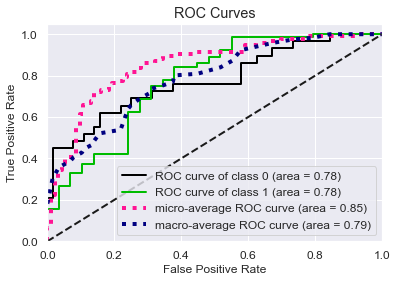

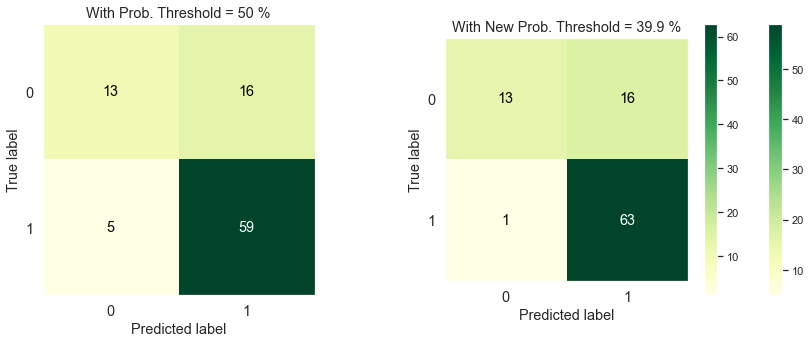

In [184]:
chosen_param = {'logit__solver': 'saga', 'logit__penalty': 'l2', 'logit__class_weight': 'balanced', 
                'logit__C': 6.2}

logit = Pipeline(steps = [
    ('scaler', StandardScaler()), 
    ('logit', LogisticRegression())
])

result = validate_on_test(logit.set_params(**chosen_param),
                          X_train_pars.values,
                          y_train.Loan_Status.values,
                          X_test_pars.values,
                          y_test.Loan_Status.values,
                          cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
                          beta = 1)

result.evaluate_model()

# XGBOOST

In [297]:
%%time

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from xgboost import XGBClassifier

params = [{
    'booster': Categorical(['dart', 'gbtree', 'gblinear']), 
    'learning_rate': Real(0.001, 0.15, prior = 'log-uniform'),
    'max_depth': Integer(3,7),
    'min_child_weight' : Integer(1,20, prior = 'log-uniform'),
    'gamma' : Real(0.001,5.0, prior = 'log-uniform'),
    'subsample': Real(0.4,0.999),
    'colsample_bytree': Real(0.3,0.999),
    'n_estimators' : Integer(10,1500), 
    'base_score': Real(0.3,0.65),
    'max_delta_step': Integer(0,10, prior = 'log-uniform'),
    'reg_alpha': Real(0.0001,2),
    'reg_lambda': Integer(1, 50)
}]

bayes_search = BayesSearchCV(estimator = XGBClassifier(use_label_encoder=False, 
                                                       eval_metric = 'error', 
                                                       objective = 'binary:logistic', 
                                                       n_jobs = -1),
                             search_spaces = params, 
                             cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle = True), 
                             scoring = 'roc_auc',
                             optimizer_kwargs = {'base_estimator': 'GP', 
                                                 'n_initial_points' : 20, 
                                                 'acq_func': 'EI', 
                                                 'n_jobs': -1},
                             n_jobs = -1) #To use all processors

tuning = 1

while tuning <2:
    bayes_search.fit(X_train_pars, y_train)
    best_accuracy = bayes_search.best_score_
    best_param = bayes_search.best_params_
    print(f'tuning: {tuning}')
    print(f'Best Accuracy: {best_accuracy*100:.4f} %')
    print(f'Best Parameters: {best_param}')
    print()
    tuning += 1

tuning: 1
Best Accuracy: 78.4658 %
Best Parameters: OrderedDict([('base_score', 0.43266277736077485), ('booster', 'dart'), ('colsample_bytree', 0.3), ('gamma', 0.001), ('learning_rate', 0.04546071012130848), ('max_delta_step', 8), ('max_depth', 7), ('min_child_weight', 5), ('n_estimators', 190), ('reg_alpha', 2.0), ('reg_lambda', 1), ('subsample', 0.999)])

Wall time: 7min 34s


       Model: *** XGBClassifier ***

Cross Validation Results on training set....
+--------+------------+--------+-----------+
| fold # | Accuracy % |  f1 %  | ROC-AUC % |
+========+============+========+===========+
| [1]    | 77.358     | 85.714 | 77.451    |
+--------+------------+--------+-----------+
| [2]    | 82.692     | 87.671 | 75.630    |
+--------+------------+--------+-----------+
| [3]    | 84.615     | 89.474 | 89.496    |
+--------+------------+--------+-----------+
| [4]    | 80.769     | 87.500 | 79.861    |
+--------+------------+--------+-----------+
| [5]    | 78.846     | 86.076 | 74.826    |
+--------+------------+--------+-----------+
| [6]    | 78.846     | 86.747 | 75        |
+--------+------------+--------+-----------+
| [7]    | 82.692     | 88.608 | 76.649    |
+--------+------------+--------+-----------+
| [8]    | 86.538     | 90.909 | 82.986    |
+--------+------------+--------+-----------+
| [9]    | 82.692     | 88.608 | 74.132    |
+--------+--------

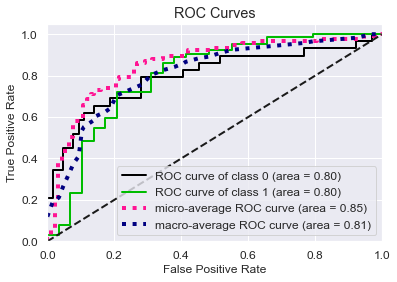

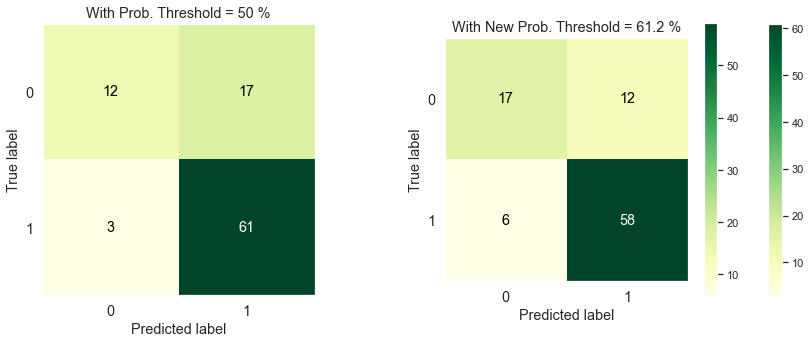

In [307]:
xgb = XGBClassifier(
    use_label_encoder=False, 
    eval_metric = 'error', 
    objective = 'binary:logistic', 
    n_jobs = -1
)

chosen_param = OrderedDict([('base_score', 0.43266277736077485), ('booster', 'dart'), 
                            ('colsample_bytree', 0.3), ('gamma', 0.001), 
                            ('learning_rate', 0.04546071012130848), ('max_delta_step', 8), 
                            ('max_depth', 7), ('min_child_weight', 5), ('n_estimators', 190), 
                            ('reg_alpha', 2.0), ('reg_lambda', 1), ('subsample', 0.999)])

result = validate_on_test(xgb.set_params(**chosen_param),
                          X_train_pars.values,
                          y_train.Loan_Status.values,
                          X_test_pars.values,
                          y_test.Loan_Status.values,
                          cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
                          beta = 1)

result.evaluate_model()

# Model Calibration

In [105]:
class calibrate_model:
    
    def __init__(self, model, Xtrain, ytrain, Xtest, ytest, cv, cal_method):
        self.model = model
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.ytest = ytest
        self.cv = cv
        self.cal_method = cal_method
        
    def calibrate_probability(self):
        
        from sklearn.model_selection import train_test_split
        from sklearn.calibration import CalibratedClassifierCV
        from sklearn.calibration import calibration_curve
        
        train_X, val_X, train_y, val_y = train_test_split(self.Xtrain, 
                                                          self.ytrain, 
                                                          test_size = 0.2, 
                                                          random_state = seed)
        
        
        #uncalibrated model
        
        for train_index, test_index in self.cv.split(train_X, train_y): 
            X_train_kfold, X_val_kfold = train_X[train_index], train_X[test_index] 
            y_train_kfold, y_val_kfold = train_y[train_index], train_y[test_index] 
            self.model.fit(X_train_kfold, y_train_kfold)
            
        uc_probs = self.model.predict_proba(self.Xtest)[:, 1]
        uc_fop, uc_mpv = calibration_curve(self.ytest, uc_probs, n_bins=10, normalize=True, 
                                           strategy = 'quantile')
        
        print()
        print(f'Uncalibrated Brier Score: {metrics.brier_score_loss(self.ytest, uc_probs)}')
        print(f'Uncalibrated ROC-AUC: {np.round(metrics.roc_auc_score(self.ytest, uc_probs)*100,3)}')
    

        #Calibrating Model
        self.cal_model = CalibratedClassifierCV(self.model, method=self.cal_method, cv=self.cv)
        self.cal_model.fit(val_X, val_y)
        
        # predict probabilities
        c_probs = self.cal_model.predict_proba(self.Xtest)[:, 1]
        
        print()
        print(f'Calibrated Brier Score: {metrics.brier_score_loss(self.ytest, c_probs)}')
        print(f'Calibrated ROC-AUC: {np.round(metrics.roc_auc_score(self.ytest, c_probs)*100,3)} %')
        print()
        
        # reliability diagram
        c_fop, c_mpv = calibration_curve(self.ytest, c_probs, n_bins=10, normalize=True,
                                        strategy = 'quantile')

        # plot CATBOOST calibrated
        plt.plot([0, 1], [0, 1], linestyle='--');

        # plot un calibrated model reliability 
        plt.plot(uc_mpv, uc_fop, marker='.', label = 'Uncalibrated');

        # plot calibrated reliability
        plt.plot(c_mpv, c_fop, marker='.', label = 'Calibrated');

        plt.title(type(self.model).__name__ + ' ' + self.cal_method)
        plt.ylabel('Fraction of Positives (fop)')
        plt.xlabel('Mean Predicted Value (mpv)')
        plt.legend();
        plt.tight_layout()

In [310]:
# defining all models

#Gaussian Process Classifier
gpc = Pipeline(steps = [
    ('scaler', StandardScaler()), 
    ('gpc', GaussianProcessClassifier(1**2 * Matern(length_scale=1, nu=1.5)))
])

#ExtraTreeForest Classifier
et = ExtraTreesClassifier( n_jobs=-1, n_estimators=384, criterion='gini', max_depth=5,
                          min_samples_split=0.01445, min_samples_leaf=4, max_features='sqrt', 
                          ccp_alpha=0.03168,  bootstrap=True, class_weight='balanced_subsample')

#CatBoost Classifier
cat = CatBoostClassifier(verbose = False, loss_function='CrossEntropy', eval_metric='TotalF1', 
                         depth=6, iterations=262, learning_rate=0.00368, l2_leaf_reg=93.38356,
                         border_count=182, boosting_type='Plain')

#Logistic Regression
logit_chosen_param = {'logit__solver': 'saga', 'logit__penalty': 'l2', 
                      'logit__class_weight': 'balanced', 'logit__C': 6.2}

logit = Pipeline(steps = [
    ('scaler', StandardScaler()), 
    ('logit', LogisticRegression())
])

logit = logit.set_params(**logit_chosen_param)

#XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric = 'error', objective = 'binary:logistic', 
                    n_jobs = -1)

xgb_chosen_param = OrderedDict([('base_score', 0.43266277736077485), ('booster', 'dart'), 
                            ('colsample_bytree', 0.3), ('gamma', 0.001), 
                            ('learning_rate', 0.04546071012130848), ('max_delta_step', 8), 
                            ('max_depth', 7), ('min_child_weight', 5), ('n_estimators', 190), 
                            ('reg_alpha', 2.0), ('reg_lambda', 1), ('subsample', 0.999)])

xgb = xgb.set_params(**xgb_chosen_param)


Uncalibrated Brier Score: 0.1503153280774903
Uncalibrated ROC-AUC: 78.772

Calibrated Brier Score: 0.1611235236356859
Calibrated ROC-AUC: 75.216 %


Uncalibrated Brier Score: 0.19893601938891353
Uncalibrated ROC-AUC: 82.031

Calibrated Brier Score: 0.15764510696641917
Calibrated ROC-AUC: 78.152 %


Uncalibrated Brier Score: 0.17608757147589926
Uncalibrated ROC-AUC: 78.718

Calibrated Brier Score: 0.16190319439895123
Calibrated ROC-AUC: 74.569 %


Uncalibrated Brier Score: 0.16886258714692876
Uncalibrated ROC-AUC: 77.64

Calibrated Brier Score: 0.15131891295977332
Calibrated ROC-AUC: 80.873 %


Uncalibrated Brier Score: 0.16688827843695905
Uncalibrated ROC-AUC: 74.03

Calibrated Brier Score: 0.2313691270599798
Calibrated ROC-AUC: 51.509 %

Wall time: 44 s
Parser   : 122 ms


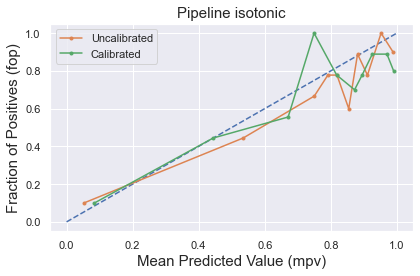

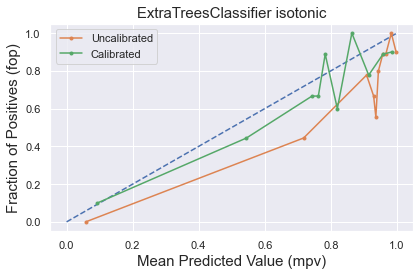

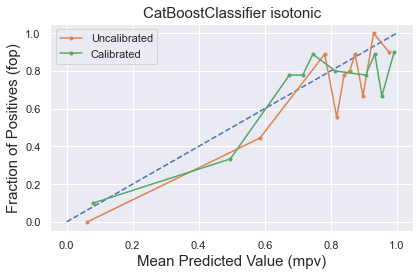

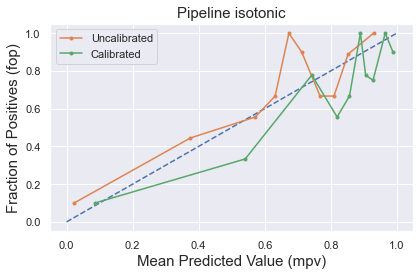

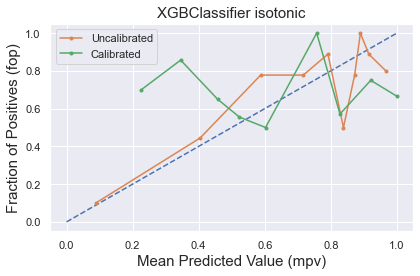

In [421]:
%%time
for model, name in zip([gpc, et, cat, logit, xgb], 
                       ['cal_gpc', 'cal_et', 'cal_cat', 'cal_logit', 'cal_xgb']):
    plt.subplots()
    model_cal = calibrate_model(model, 
                            X_train_pars.values, 
                            y_train.Loan_Status.values, 
                            X_test_pars, 
                            y_test.Loan_Status,
                            cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
                            cal_method = 'isotonic')
    
    model_cal.calibrate_probability()
    
    name = model_cal.cal_model

In [331]:
cal_XGB = model_cal.cal_model

### Evaluating all Calibrated Classifiers

       Model: *** CalibratedClassifierCV ***

Cross Validation Results on training set....
+--------+------------+--------+-----------+
| fold # | Accuracy % |  f1 %  | ROC-AUC % |
+========+============+========+===========+
| [1]    | 77.358     | 85.714 | 76.225    |
+--------+------------+--------+-----------+
| [2]    | 84.615     | 89.474 | 79.916    |
+--------+------------+--------+-----------+
| [3]    | 84.615     | 89.474 | 83.697    |
+--------+------------+--------+-----------+
| [4]    | 82.692     | 88.889 | 82.726    |
+--------+------------+--------+-----------+
| [5]    | 80.769     | 87.179 | 78.472    |
+--------+------------+--------+-----------+
| [6]    | 78.846     | 86.747 | 73.785    |
+--------+------------+--------+-----------+
| [7]    | 84.615     | 89.744 | 74.653    |
+--------+------------+--------+-----------+
| [8]    | 90.385     | 93.506 | 85.677    |
+--------+------------+--------+-----------+
| [9]    | 78.846     | 85.714 | 72.396    |
+--------

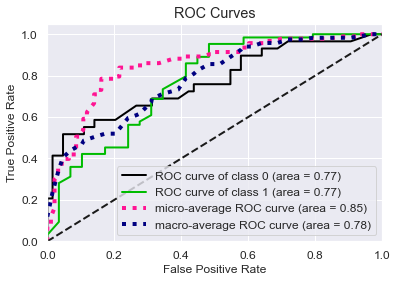

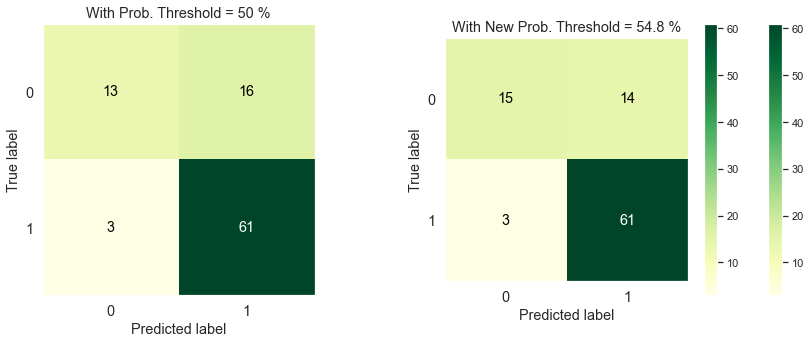

In [332]:
cal_gpc_result = validate_on_test(cal_gpc,
                          X_train_pars.values,
                          y_train.Loan_Status.values,
                          X_test_pars.values,
                          y_test.Loan_Status.values,
                          cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
                          beta = 1)

cal_gpc_result.evaluate_model()

       Model: *** CalibratedClassifierCV ***

Cross Validation Results on training set....
+--------+------------+--------+-----------+
| fold # | Accuracy % |  f1 %  | ROC-AUC % |
+========+============+========+===========+
| [1]    | 79.245     | 86.747 | 73.203    |
+--------+------------+--------+-----------+
| [2]    | 82.692     | 88     | 84.202    |
+--------+------------+--------+-----------+
| [3]    | 82.692     | 88.312 | 83.193    |
+--------+------------+--------+-----------+
| [4]    | 82.692     | 88.889 | 80.382    |
+--------+------------+--------+-----------+
| [5]    | 76.923     | 85     | 78.212    |
+--------+------------+--------+-----------+
| [6]    | 78.846     | 86.747 | 75.434    |
+--------+------------+--------+-----------+
| [7]    | 82.692     | 88.608 | 72.309    |
+--------+------------+--------+-----------+
| [8]    | 88.462     | 92.105 | 84.549    |
+--------+------------+--------+-----------+
| [9]    | 80.769     | 87.500 | 74.479    |
+--------

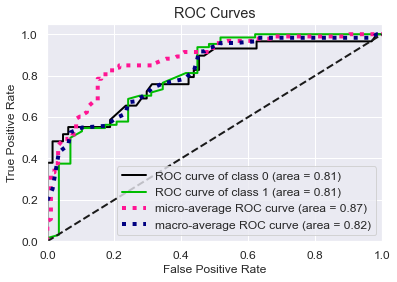

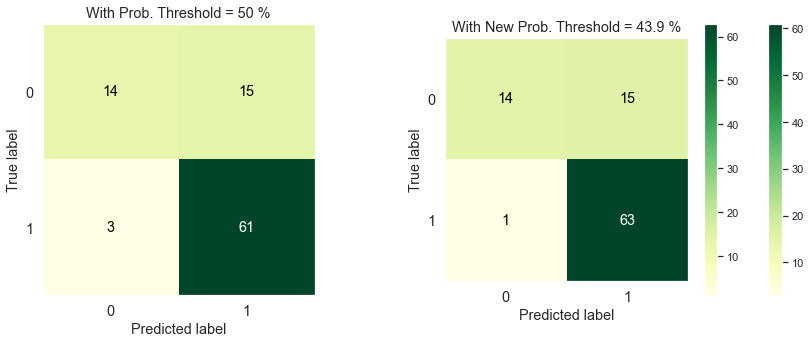

In [333]:
cal_et_result = validate_on_test(cal_et,
                          X_train_pars.values,
                          y_train.Loan_Status.values,
                          X_test_pars.values,
                          y_test.Loan_Status.values,
                          cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
                          beta = 1)

cal_et_result.evaluate_model()

       Model: *** CalibratedClassifierCV ***

Cross Validation Results on training set....
+--------+------------+--------+-----------+
| fold # | Accuracy % |  f1 %  | ROC-AUC % |
+========+============+========+===========+
| [1]    | 79.245     | 86.747 | 74.755    |
+--------+------------+--------+-----------+
| [2]    | 80.769     | 86.486 | 76.639    |
+--------+------------+--------+-----------+
| [3]    | 76.923     | 84.211 | 84.958    |
+--------+------------+--------+-----------+
| [4]    | 84.615     | 90     | 87.500    |
+--------+------------+--------+-----------+
| [5]    | 78.846     | 85.714 | 74.392    |
+--------+------------+--------+-----------+
| [6]    | 80.769     | 87.805 | 78.125    |
+--------+------------+--------+-----------+
| [7]    | 76.923     | 84.211 | 74.913    |
+--------+------------+--------+-----------+
| [8]    | 90.385     | 93.506 | 84.983    |
+--------+------------+--------+-----------+
| [9]    | 76.923     | 83.784 | 73.177    |
+--------

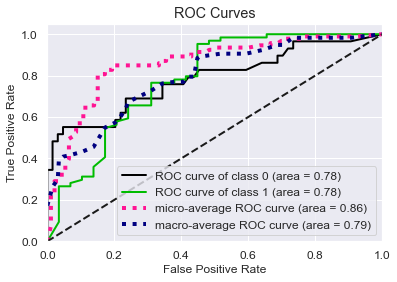

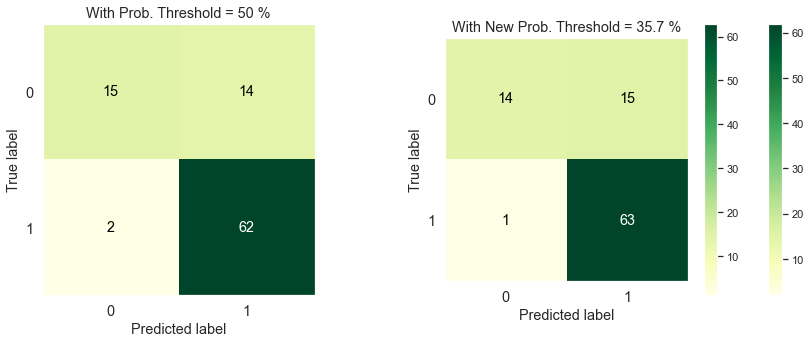

In [334]:
cal_cat_result = validate_on_test(cal_cat,
                          X_train_pars.values,
                          y_train.Loan_Status.values,
                          X_test_pars.values,
                          y_test.Loan_Status.values,
                          cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
                          beta = 1)

cal_cat_result.evaluate_model()

       Model: *** CalibratedClassifierCV ***

Cross Validation Results on training set....
+--------+------------+--------+-----------+
| fold # | Accuracy % |  f1 %  | ROC-AUC % |
+========+============+========+===========+
| [1]    | 77.358     | 85.714 | 73.693    |
+--------+------------+--------+-----------+
| [2]    | 80.769     | 86.486 | 82.773    |
+--------+------------+--------+-----------+
| [3]    | 82.692     | 88.312 | 82.269    |
+--------+------------+--------+-----------+
| [4]    | 78.846     | 86.076 | 75.347    |
+--------+------------+--------+-----------+
| [5]    | 78.846     | 86.076 | 76.215    |
+--------+------------+--------+-----------+
| [6]    | 78.846     | 86.747 | 72.569    |
+--------+------------+--------+-----------+
| [7]    | 82.692     | 88.608 | 73.611    |
+--------+------------+--------+-----------+
| [8]    | 86.538     | 90.667 | 81.771    |
+--------+------------+--------+-----------+
| [9]    | 78.846     | 86.420 | 78.125    |
+--------

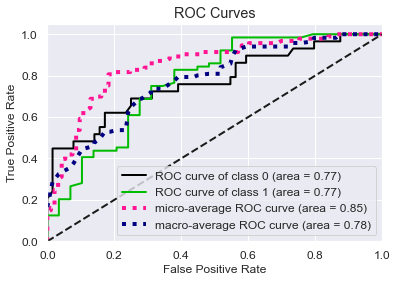

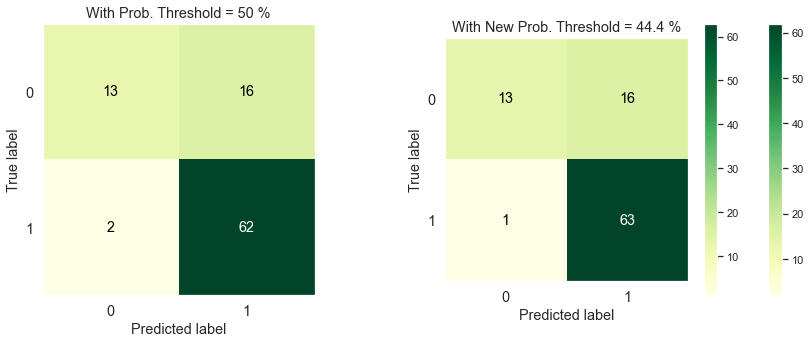

In [335]:
cal_logit_result = validate_on_test(cal_logit,
                          X_train_pars.values,
                          y_train.Loan_Status.values,
                          X_test_pars.values,
                          y_test.Loan_Status.values,
                          cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
                          beta = 1)

cal_logit_result.evaluate_model()

       Model: *** CalibratedClassifierCV ***

Cross Validation Results on training set....
+--------+------------+--------+-----------+
| fold # | Accuracy % |  f1 %  | ROC-AUC % |
+========+============+========+===========+
| [1]    | 77.358     | 85.714 | 74.918    |
+--------+------------+--------+-----------+
| [2]    | 84.615     | 88.889 | 73.445    |
+--------+------------+--------+-----------+
| [3]    | 84.615     | 89.474 | 87.563    |
+--------+------------+--------+-----------+
| [4]    | 80.769     | 87.500 | 82.378    |
+--------+------------+--------+-----------+
| [5]    | 80.769     | 87.179 | 73.958    |
+--------+------------+--------+-----------+
| [6]    | 78.846     | 86.747 | 75.955    |
+--------+------------+--------+-----------+
| [7]    | 80.769     | 87.179 | 75.868    |
+--------+------------+--------+-----------+
| [8]    | 86.538     | 90.909 | 82.465    |
+--------+------------+--------+-----------+
| [9]    | 80.769     | 86.842 | 75.347    |
+--------

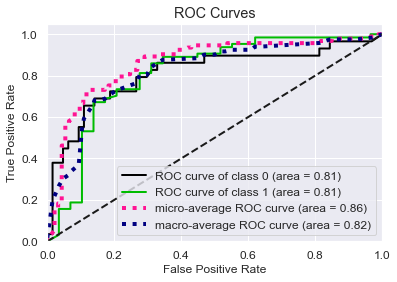

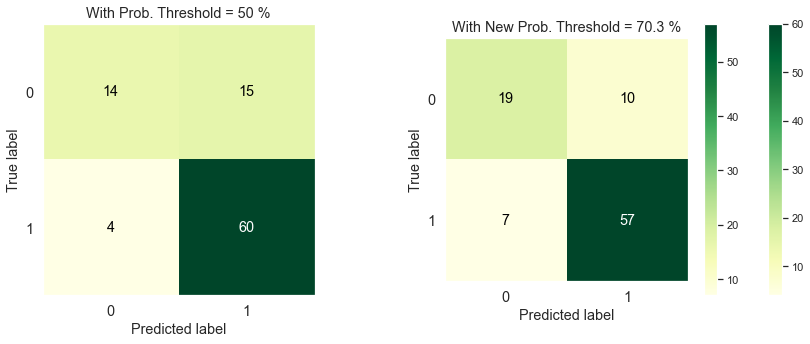

In [336]:
cal_XGB_result = validate_on_test(cal_XGB,
                          X_train_pars.values,
                          y_train.Loan_Status.values,
                          X_test_pars.values,
                          y_test.Loan_Status.values,
                          cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
                          beta = 1)

cal_XGB_result.evaluate_model()

# Voting Classifier

I will combine all of the above calibrated classifiers to form an ensemble voting classifier that uses soft voting to predict the probabilities of all of these classifiers and then set the appropriate threshold for prediciting the classes.

In [425]:
from mlxtend.classifier import EnsembleVoteClassifier

evc = EnsembleVoteClassifier(clfs=[cal_gpc, cal_et, cal_cat, cal_logit, cal_XGB], 
                             voting = 'soft')

Wall time: 0 ns


       Model: *** EnsembleVoteClassifier ***

Cross Validation Results on training set....
+--------+------------+--------+-----------+
| fold # | Accuracy % |  f1 %  | ROC-AUC % |
+========+============+========+===========+
| [1]    | 77.358     | 85.714 | 76.144    |
+--------+------------+--------+-----------+
| [2]    | 78.846     | 84.932 | 79.664    |
+--------+------------+--------+-----------+
| [3]    | 82.692     | 88.608 | 86.218    |
+--------+------------+--------+-----------+
| [4]    | 82.692     | 88.889 | 83.507    |
+--------+------------+--------+-----------+
| [5]    | 76.923     | 85     | 77.951    |
+--------+------------+--------+-----------+
| [6]    | 78.846     | 86.747 | 75.868    |
+--------+------------+--------+-----------+
| [7]    | 82.692     | 88.608 | 75.347    |
+--------+------------+--------+-----------+
| [8]    | 90.385     | 93.506 | 84.028    |
+--------+------------+--------+-----------+
| [9]    | 82.692     | 88.608 | 74.306    |
+--------

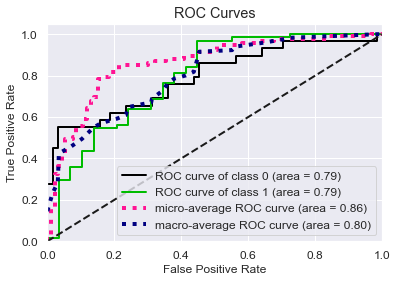

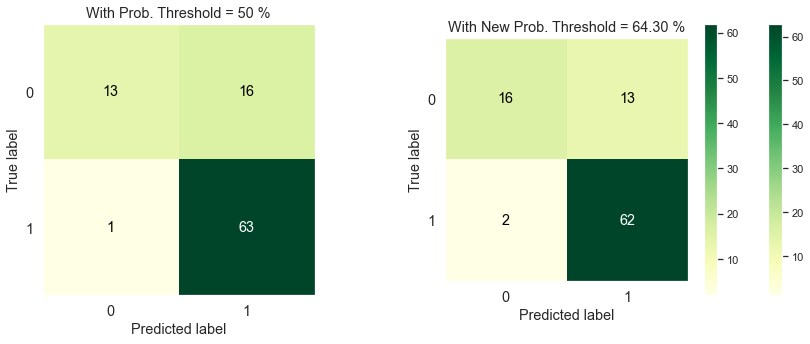

In [440]:
%%time
evc_result = validate_on_test(evc,
                          X_train_pars.values,
                          y_train.Loan_Status.values,
                          X_test_pars.values,
                          y_test.Loan_Status.values,
                          cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
                          beta = 0.5)

evc_result.evaluate_model()

Ensemble voting classifier has managed to achive the highest accuracy of almost 84% with the lowest false positive rate compared to other models. In this context, false postives represents those applicants who are generally rejected for loan approval. <br>
<br>
As this dataset si taken from a data science competition website, I will now train the ensemble model on the entire dataset and test it on the TEST_DF. After that I will uploaded the predicitons and check the score I received. 

# Submission

In [407]:
full_df = X_train_pars.append(X_test_pars, ignore_index=True)
full_target_df = y_train.append(y_test, ignore_index=True)
full_df.shape, full_target_df.shape

((614, 7), (614, 1))

In [415]:
skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle = True)

train = full_df.values
target = full_target_df.Loan_Status.values

score = []
fold_no = 1

for train_index, test_index in skf.split(train, target):
    print(f'{fold_no} of kfold {skf.n_splits}')
    X_train_kfold, X_val_kfold = train[train_index], train[test_index]
    y_train_kfold, y_val_kfold = target[train_index], target[test_index]
    
    classifier = evc
    
    classifier.fit(X_train_kfold, y_train_kfold) 
    y_pred = classifier.predict(X_val_kfold)
    print(f'Accuracy: {metrics.accuracy_score(y_val_kfold, y_pred)*100} %')
    score.append(metrics.accuracy_score(y_val_kfold, y_pred))
    fold_no += 1
print()
print(f'Mean CV Accuracy: {np.round(np.mean(score)*100,3)} ± {np.round(np.std(score)*100,1)} %')
print()
print("---" * 40)

predictions = classifier.predict(TEST_DF_pars.values)
probs = classifier.predict_proba(TEST_DF_pars.values)[:,1]

1 of kfold 10
Accuracy: 85.48387096774194 %
2 of kfold 10
Accuracy: 72.58064516129032 %
3 of kfold 10
Accuracy: 87.09677419354838 %
4 of kfold 10
Accuracy: 77.41935483870968 %
5 of kfold 10
Accuracy: 90.1639344262295 %
6 of kfold 10
Accuracy: 77.04918032786885 %
7 of kfold 10
Accuracy: 85.24590163934425 %
8 of kfold 10
Accuracy: 77.04918032786885 %
9 of kfold 10
Accuracy: 83.60655737704919 %
10 of kfold 10
Accuracy: 81.9672131147541 %

Mean CV Accuracy: 81.766 ± 5.3 %

------------------------------------------------------------------------------------------------------------------------


In [416]:
submission = pd.read_csv('sample_submission_49d68Cx.csv')
submission['Loan_Status'] = np.where(probs > 0.6370, 'Y', 'N')

In [417]:
submission

Loan_ID Loan_Status
0    LP001015           Y
1    LP001022           Y
2    LP001031           Y
3    LP001035           Y
4    LP001051           N
..        ...         ...
362  LP002971           Y
363  LP002975           Y
364  LP002980           Y
365  LP002986           Y
366  LP002989           Y

[367 rows x 2 columns]

In [418]:
submission.to_csv('submission.csv', index=False)

After submission, I managed to get a score of **81.25% on the score board!!**

# Explainability

In [474]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(training_data=X_train_pars.values, 
                                              feature_names=X_train_pars.columns, 
                                              class_names=['Rejected', 'Approved'], 
                                              mode="classification")

In [431]:
#Looking through the prediciton with the highest probability
np.argmax(evc_result.y_probs[:,1])

75

In [433]:
#Looking through the prediciton with the lowest probability
np.argmin(evc_result.y_probs[:,1])

21

In [432]:
#High Probability
evc_result.y_probs[:,1][75]

0.9635736985457223

In [434]:
#low Probability
evc_result.y_probs[:,1][21]

0.016597086701962253

#### What are the attributes of applicants who got their loan applications rejected?

In [497]:
#Looking at the prediciton with the highest probability of loan approval

explained = explainer.explain_instance(X_test_pars.values[75], evc.predict_proba,  num_features=7)

explained.show_in_notebook(show_table=True, show_all=False);

In the right, we see how influential the features were. The precise values of the features for this applicant is displayed on the table. This applicant has 96 % probability of getting their loan application approved. Lets look at this applicant's attributes: <br>
<br>
* **Property Area**: Encoded dictionary for this feature:<br>
<br>**Rural**: -0.2933489045398163, **Semi-Urban**: 0.36028188646011855, **Urban**: -0.10229366777710712<br>
<br>
>>> This applicant owns property in Semi-urban location.<br>
<br>
* **Dependents**: <br>
The encoding distionary for the number of dependents are as follows: <br>
<br>**0**: -0.008796725096963293, **1**: -0.2579386563252689, **2**: 0.29656203094338324, **3+**: 0.06051507479326561 <br>
<br>
>>> This applicant has 2 dependents. <br>
<br>
* **Debt_income_ratio**: The lower the debt_income ratio, the better will be an applicant's financial stability. This applicant's debt to income rario is considered low. <br>
<br>
* **EMI**: The EMI the applicant has to pay is not quite high. <br>
<br>
* **Married**: The encodins are: **Not Married**: -0.24411655597228846, **Married**: 0.14413725629617619 <br>
<br>
>>> This applicant is married. <br>
<br>
* **LoanAmount**: This applicant requested a loan aount of 97000, which is not quite high according to the bank. <br>
<br>
* **Credit History**: **0.0**: -3.2577031934071985, **1.0**: 0.5550598129551189 <br>
<br>
>>> This applicant has a good credit history. This has to be the highest influential attribute in determining loan approval.<br>
<br>
<br>
<br>

The highest feature importance are for property area, Dependents and debt to income ratio as shown in the figure. According to the bank, this applicant has all the right attriutes to get their loan approved.



In [498]:
#Looking at the prediciton with the lowest probability of loan approval

explained = explainer.explain_instance(X_test_pars.values[21], evc.predict_proba,  num_features=7)

explained.show_in_notebook(show_table=True, show_all=False);

These attributes are for the applicant who has the lowest probability of getting their loan approved (only 2 %). 

* First, this applicant has a bad credit history. <br>
<br>
* Second, this applicant owns a property in an Urban area. During EDA, data showed that bank prefers someone owning property in semi-urban area. <br>
<br>
* This applicant is unmarried. During EDA, we have seen that unmarried applicants have a higher propoetion of loan applicantions being rejected. <br>
<br>
 
 
All of these attributes contributes to the applicant's loan application being rejected.